# Part 3: Model Evaluation for Imbalanced Data

### 3.1 Class Imbalance Considerations

##### 3.1.1 Why Accuracy Fails: Demonstrate with concrete examples why accuracy is misleading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, roc_curve
)

# Sample Data Loaded
np.random.seed(42)

# Simulate imbalanced dataset similar to customer churn
# getting 27% as churn rate
n_samples = 1000
churn_rate = 0.27  

y_true = np.random.choice([0, 1], size=n_samples, p=[1-churn_rate, churn_rate])
print(f"Class Distribution:")
print(f"No Churn (0): {np.sum(y_true == 0)} ({np.sum(y_true == 0)/len(y_true)*100:.1f}%)")
print(f"Churn (1): {np.sum(y_true == 1)} ({np.sum(y_true == 1)/len(y_true)*100:.1f}%)")

Class Distribution:
No Churn (0): 739 (73.9%)
Churn (1): 261 (26.1%)


##### - Scenario 1: The "Lazy" Classifier

In [ ]:
y_pred_lazy = np.zeros(n_samples)  

accuracy_lazy = accuracy_score(y_true, y_pred_lazy)
print(f"\n🚨 MISLEADING RESULT:")
print(f"'Lazy' Model Accuracy: {accuracy_lazy:.3f} ({accuracy_lazy*100:.1f}%)")
print("This model NEVER correctly identifies a churning customer!")


🚨 MISLEADING RESULT:
'Lazy' Model Accuracy: 0.739 (73.9%)
This model NEVER correctly identifies a churning customer!


##### - Scenario 2: A Realistic Model

In [4]:
y_pred_realistic = y_true.copy()

churn_indices = np.where(y_true == 1)[0]
missed_churners = np.random.choice(churn_indices, size=int(0.6 * len(churn_indices)), replace=False)
y_pred_realistic[missed_churners] = 0  

accuracy_realistic = accuracy_score(y_true, y_pred_realistic)
precision_realistic = precision_score(y_true, y_pred_realistic)
recall_realistic = recall_score(y_true, y_pred_realistic)

print(f"\n📊 REALISTIC MODEL PERFORMANCE:")
print(f"Accuracy: {accuracy_realistic:.3f} ({accuracy_realistic*100:.1f}%)")
print(f"Precision: {precision_realistic:.3f}")
print(f"Recall: {recall_realistic:.3f}")
print(f"This model misses {(1-recall_realistic)*100:.0f}% of churning customers!")


📊 REALISTIC MODEL PERFORMANCE:
Accuracy: 0.844 (84.4%)
Precision: 1.000
Recall: 0.402
This model misses 60% of churning customers!


##### Comparison of Confusion Matrices

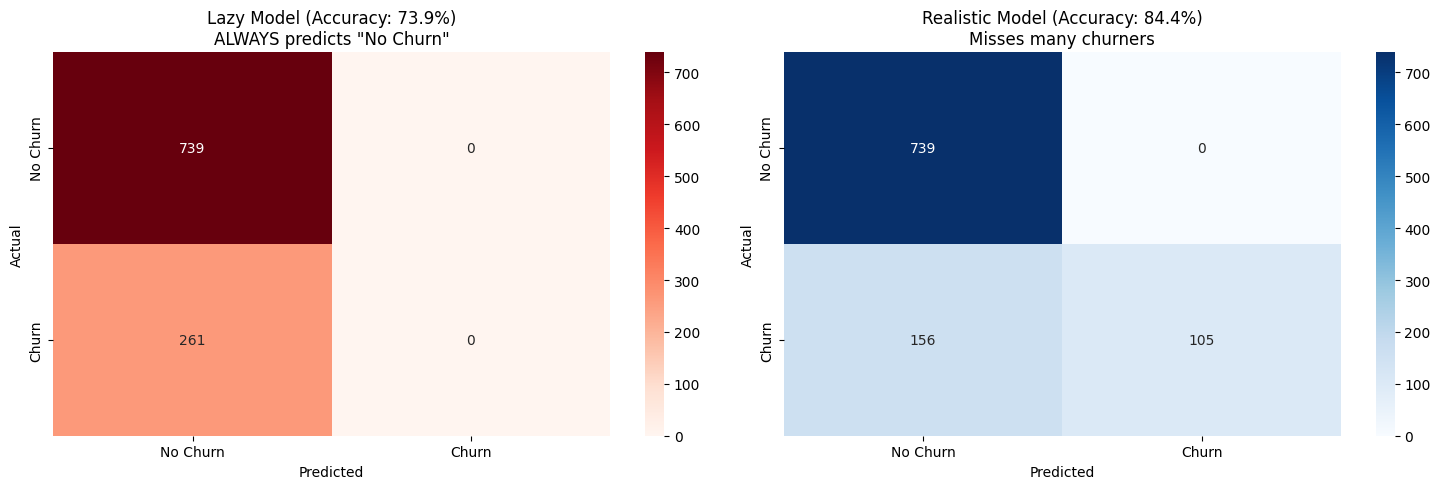

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Lazy model confusion matrix
cm_lazy = confusion_matrix(y_true, y_pred_lazy)
sns.heatmap(cm_lazy, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title(f'Lazy Model (Accuracy: {accuracy_lazy:.1%})\nALWAYS predicts "No Churn"')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Realistic model confusion matrix
cm_realistic = confusion_matrix(y_true, y_pred_realistic)
sns.heatmap(cm_realistic, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title(f'Realistic Model (Accuracy: {accuracy_realistic:.1%})\nMisses many churners')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

##### 3.1.2 Business Impact: Explain cost of false positives vs. false negatives in churn prediction

In [9]:
# Calculate business costs
total_churners = np.sum(y_true == 1)
missed_churners_lazy = total_churners  
missed_churners_realistic = np.sum((y_true == 1) & (y_pred_realistic == 0))

'''Annual revenue per customer, Cost to retain a customer, Cost to acquire a new customer'''
avg_customer_value = 1200  
retention_cost = 100       
acquisition_cost = 300     

print(f"BUSINESS ASSUMPTIONS:")
print(f"• Average Customer Annual Value: ${avg_customer_value:,}")
print(f"• Cost to Retain a Customer: ${retention_cost:,}")
print(f"• Cost to Acquire New Customer: ${acquisition_cost:,}")
print(f"• Total Churners in Dataset: {total_churners}")

BUSINESS ASSUMPTIONS:
• Average Customer Annual Value: $1,200
• Cost to Retain a Customer: $100
• Cost to Acquire New Customer: $300
• Total Churners in Dataset: 261


In [11]:
# Calculate losses
loss_lazy = missed_churners_lazy * (avg_customer_value + acquisition_cost)
loss_realistic = missed_churners_realistic * (avg_customer_value + acquisition_cost)

print(f"\n💰 FINANCIAL IMPACT:")
print(f"Lazy Model:")
print(f"  • Missed Churners: {missed_churners_lazy}")
print(f"  • Lost Revenue: ${loss_lazy:,}")
print(f"  • Cost per Customer: ${loss_lazy/total_churners:,.0f}")

print(f"\nRealistic Model:")
print(f"  • Missed Churners: {missed_churners_realistic}")
print(f"  • Lost Revenue: ${loss_realistic:,}")
print(f"  • Savings vs Lazy Model: ${loss_lazy - loss_realistic:,}")




💰 FINANCIAL IMPACT:
Lazy Model:
  • Missed Churners: 261
  • Lost Revenue: $391,500
  • Cost per Customer: $1,500

Realistic Model:
  • Missed Churners: 156
  • Lost Revenue: $234,000
  • Savings vs Lazy Model: $157,500


In [13]:
# False Positive vs False Negative Costs
print(f"\n COST ANALYSIS: FALSE POSITIVES vs FALSE NEGATIVES")
print("-"*60)

# False Negatives: Predicting No Churn when customer actually churns
fn_lazy = np.sum((y_true == 1) & (y_pred_lazy == 0))
fn_realistic = np.sum((y_true == 1) & (y_pred_realistic == 0))

# False Positives: Predicting Churn when customer doesn't churn
fp_lazy = np.sum((y_true == 0) & (y_pred_lazy == 1))
fp_realistic = np.sum((y_true == 0) & (y_pred_realistic == 1))

cost_per_fn = avg_customer_value + acquisition_cost  
cost_per_fp = retention_cost  

print(f"False Negative Cost (Missing a churner): ${cost_per_fn:,}")
print(f"False Positive Cost (Unnecessary retention): ${cost_per_fp:,}")
print(f"FN cost is {cost_per_fn/cost_per_fp:.1f}x higher than FP cost!")

total_cost_lazy = (fn_lazy * cost_per_fn) + (fp_lazy * cost_per_fp)
total_cost_realistic = (fn_realistic * cost_per_fn) + (fp_realistic * cost_per_fp)

print(f"\n TOTAL BUSINESS COST:")
print(f"Lazy Model: ${total_cost_lazy:,}")
print(f"Realistic Model: ${total_cost_realistic:,}")
print(f"Improvement: ${total_cost_lazy - total_cost_realistic:,}")

print(f"\n KEY TAKEAWAYS:")
print("1. Accuracy is MISLEADING in imbalanced datasets")
print("2. A 73% accurate 'lazy' model is USELESS for business")
print("3. False Negatives are much more costly than False Positives")
print("4. Focus on RECALL (catching churners) over precision")
print("5. Use business-aware metrics for model evaluation")


 COST ANALYSIS: FALSE POSITIVES vs FALSE NEGATIVES
------------------------------------------------------------
False Negative Cost (Missing a churner): $1,500
False Positive Cost (Unnecessary retention): $100
FN cost is 15.0x higher than FP cost!

 TOTAL BUSINESS COST:
Lazy Model: $391,500
Realistic Model: $234,000
Improvement: $157,500

 KEY TAKEAWAYS:
1. Accuracy is MISLEADING in imbalanced datasets
2. A 73% accurate 'lazy' model is USELESS for business
3. False Negatives are much more costly than False Positives
4. Focus on RECALL (catching churners) over precision
5. Use business-aware metrics for model evaluation


## 3.2  Comprehensive Evaluation Metrics 

- This part is done, under the **Part_02_Advanced_Model_Pipeline.ipynb** section (Check Last Part)

## 3.3 Model Comparison Framework

- This part is done, under the **Part_02_Advanced_Model_Pipeline.ipynb** section (Check Last Part)